In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load ArUco dictionary and parameters
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
parameters = cv2.aruco.DetectorParameters()

# Open the main video and extract the first frame
cap_main = cv2.VideoCapture("video.mp4")
if not cap_main.isOpened():
    print("Error: Could not open video.mp4.")
    exit()

ret_main, frame_main = cap_main.read()
if not ret_main or frame_main is None:
    print("Error: Could not read a valid frame from video.mp4.")
    cap_main.release()
    exit()

# Convert frame to grayscale and detect markers
gray = cv2.cvtColor(frame_main, cv2.COLOR_BGR2GRAY)
corners, ids, _ = cv2.aruco.detectMarkers(gray, dictionary, parameters=parameters)

if ids is not None and len(ids) >= 4:
    # Extract ROI corner points from markers
    roi_corners = {}
    for marker_id, corner_set in zip(ids.flatten(), corners):
        roi_corners[marker_id] = corner_set[0]

    # Ensure all 4 required markers exist
    required_ids = [23, 25, 30, 33]
    if all(marker_id in roi_corners for marker_id in required_ids):
        ref_pt1 = roi_corners[23][0]  # Top-left
        ref_pt2 = roi_corners[25][1]  # Top-right
        ref_pt3 = roi_corners[30][2]  # Bottom-right
        ref_pt4 = roi_corners[33][3]  # Bottom-left

        # Define destination points (ROI in video.mp4)
        pts_dst = np.array([
            [ref_pt1[0], ref_pt1[1]],
            [ref_pt2[0], ref_pt2[1]],
            [ref_pt3[0], ref_pt3[1]],
            [ref_pt4[0], ref_pt4[1]]
        ], dtype=np.float32)

        print("Destination ROI Points:", pts_dst)
else:
    print("Error: Not all ArUco markers detected.")
    exit()

cap_main.release()


Destination ROI Points: [[ 244.  360.]
 [ 917.  360.]
 [ 414. 1222.]
 [ 736. 1225.]]


In [9]:
# Open the source video (piano.mp4)
cap_piano = cv2.VideoCapture("piano.mp4")
if not cap_piano.isOpened():
    print("Error: Could not open piano.mp4.")
    exit()

# Read the first frame of the source video
ret_piano, frame_piano = cap_piano.read()
if not ret_piano or frame_piano is None:
    print("Error: Could not read a valid frame from piano.mp4.")
    cap_piano.release()
    exit()

# Compute ROI dimensions
roi_width = int(np.linalg.norm(ref_pt1 - ref_pt2))
roi_height = int(np.linalg.norm(ref_pt1 - ref_pt3))

# Compute aspect ratios
roi_aspect_ratio = roi_width / roi_height
src_height, src_width, _ = frame_piano.shape
src_aspect_ratio = src_width / src_height

# Crop source video to match aspect ratio
if src_aspect_ratio > roi_aspect_ratio:
    new_width = int(src_height * roi_aspect_ratio)
    crop_x = (src_width - new_width) // 2
    frame_piano = frame_piano[:, crop_x:crop_x + new_width]
elif src_aspect_ratio < roi_aspect_ratio:
    new_height = int(src_width / roi_aspect_ratio)
    crop_y = (src_height - new_height) // 2
    frame_piano = frame_piano[crop_y:crop_y + new_height, :]

# Resize after cropping
frame_piano = cv2.resize(frame_piano, (roi_width, roi_height))

# Define source points (entire `piano.mp4` frame)
pts_src = np.array([
    [0, 0], 
    [roi_width, 0], 
    [roi_width, roi_height], 
    [0, roi_height]
], dtype=np.float32)

print("Source Video Points:", pts_src)

cap_piano.release()


Source Video Points: [[  0.   0.]
 [673.   0.]
 [673. 878.]
 [  0. 878.]]


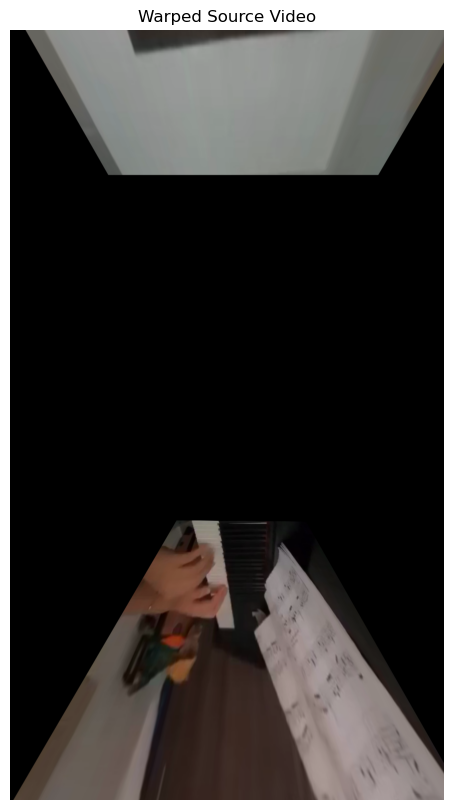

In [10]:
# Compute perspective transform
M = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Warp the piano video frame to fit into the detected region
warped_piano = cv2.warpPerspective(frame_piano, M, (frame_main.shape[1], frame_main.shape[0]))

# Display warped video
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(warped_piano, cv2.COLOR_BGR2RGB))
plt.title("Warped Source Video")
plt.axis("off")
plt.show()
